In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from cvx_portfolio.costs import TcostModel
from cvx_portfolio.returns import AlphaSource
from cvx_portfolio.simulator import MarketSimulator
from cvx_portfolio.policies import SinglePeriodOpt, Hold
from cvx_portfolio.data import generate_alpha_signal, series_factor_model_covariance
from cvx_portfolio.risks import EmpSigma, FactorModelSigma
from cvx_portfolio.constraints import LeverageLimit  

plotdir = '../portfolio/plots/'
datadir= '../equity_data_tool/'

## Download data using ee103 code (to be integrated) 

In [2]:
sigmas=pd.read_csv(datadir+'sigmas.txt',index_col=0,parse_dates=[0])
returns=pd.read_csv(datadir+'returns.txt',index_col=0,parse_dates=[0])
volumes=pd.read_csv(datadir+'volumes.txt',index_col=0,parse_dates=[0])
prices=pd.read_csv(datadir+'prices.txt',index_col=0,parse_dates=[0])

In [3]:
np.random.seed(1)
alpha_signal=generate_alpha_signal(real_returns=returns, IC=0.01, type_noise='OU')
alpha_signal = 0.01 * alpha_signal
alpha_signal.USDOLLAR = returns.USDOLLAR

alpha_model = AlphaSource(alpha_signal)

/home/enzo/repos/cvx_portfolio/cvx_portfolio/data/generator.py:30: RuntimeWarning: overflow encountered in exp
  sig*ex*np.concatenate([[0],np.cumsum(np.sqrt(np.diff(np.exp(2*th*t)-1))*np.random.randn(len(t)-1))])
/home/enzo/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:1578: RuntimeWarning: invalid value encountered in subtract
  return a[slice1]-a[slice2]


### Compute factor risk model 

In [4]:
exposures_pan, factor_sigma_pan, idyos_df = series_factor_model_covariance(returns, 
                                                                           variance_explained=.75,
                                                                           freq='MS',
                                    lookback_periods = 12)

#risk_model = EmpSigma(returns, lookback=500)
risk_model = FactorModelSigma(exposures_pan, factor_sigma_pan, idyos_df)

### Transaction costs model

In [5]:
del volumes['USDOLLAR']
del sigmas['USDOLLAR']

spread = pd.DataFrame(data=5e-4, index=volumes.index, columns=volumes.columns)
nonlin_coeff = pd.DataFrame(data=1, index=volumes.index, columns=volumes.columns)
simulated_tcost = TcostModel(volumes, sigmas, spread, nonlin_coeff, cash_key='USDOLLAR')

## Market simulator 

In [6]:
simulator = MarketSimulator(returns, volumes, [simulated_tcost], cash_key='USDOLLAR')

## Portfolio

In [140]:
p = pd.Series(index=returns.columns, data=1)
p.USDOLLAR=0.
weights=p/sum(p)
p_0 = 1E8*p

## Policy

In [165]:
gamma_tcost=1.
policies={}
for lev in [1, 1.5, 2, 2.5, 3]:
    for risk in [.5,10,100, 1000] : 
        policies[(risk, lev)] = \
                SinglePeriodOpt(alpha_model, [risk*risk_model, gamma_tcost*simulated_tcost], 
                                [LeverageLimit(lev)])

## Simulations

In [167]:
results=dict(zip(policies.keys(), 
                 simulator.run_multiple_backtest(p_0, start_time="2012-01-01",end_time="2016-12-31",
                                              policies=policies.values(), parallel=True)))

In [170]:
results

{(0.5, 1): <cvx_portfolio.result.SimulationResult at 0x7f922c3c3438>,
 (0.5, 1.5): <cvx_portfolio.result.SimulationResult at 0x7f922c3e35f8>,
 (0.5, 2): <cvx_portfolio.result.SimulationResult at 0x7f922c3493c8>,
 (0.5, 2.5): <cvx_portfolio.result.SimulationResult at 0x7f922c3f9198>,
 (0.5, 3): <cvx_portfolio.result.SimulationResult at 0x7f922c36f0b8>,
 (10, 1): <cvx_portfolio.result.SimulationResult at 0x7f922c3c6668>,
 (10, 1.5): <cvx_portfolio.result.SimulationResult at 0x7f922c3541d0>,
 (10, 2): <cvx_portfolio.result.SimulationResult at 0x7f922c31fe48>,
 (10, 2.5): <cvx_portfolio.result.SimulationResult at 0x7f922c3af470>,
 (10, 3): <cvx_portfolio.result.SimulationResult at 0x7f922c4e1080>,
 (100, 1): <cvx_portfolio.result.SimulationResult at 0x7f922c3fae48>,
 (100, 1.5): <cvx_portfolio.result.SimulationResult at 0x7f922c304f60>,
 (100, 2): <cvx_portfolio.result.SimulationResult at 0x7f922c3548d0>,
 (100, 2.5): <cvx_portfolio.result.SimulationResult at 0x7f922c3f92b0>,
 (100, 3): <c

In [187]:
result_df=pd.DataFrame()
for k in results:
    result_df.loc[k[0], float(k[1])]= results[k]
result_df.index.name = 'gamma_risk'
result_df.columns.name = 'leverage'
result_df = result_df.reindex(index=sorted(result_df.index),columns=sorted(result_df.columns))

In [191]:
result_df=result_df.loc[result_df.index[:3]]
result_df=result_df[[1,2,3]]

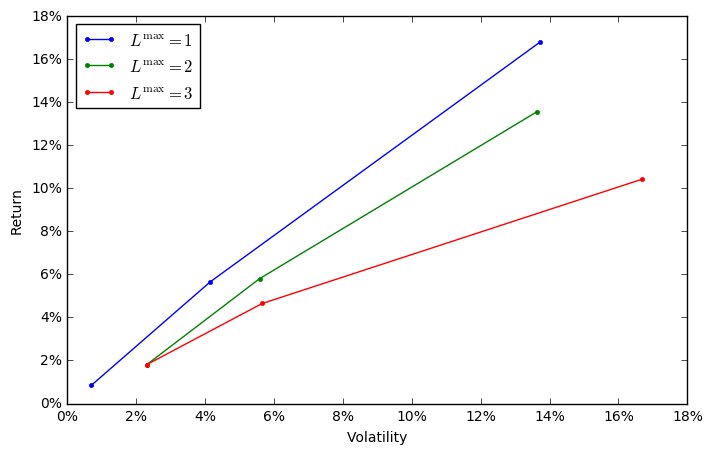

In [192]:
plt.figure(figsize=(8,5))
for leverage in result_df.columns:
    x = [100*result_df.loc[(i, leverage)].volatility for i in result_df.index]
    y = [100*result_df.loc[(i, leverage)].mean_return for i in result_df.index]
    plt.plot(np.array(x),np.array(y), '.-', label=r'$L^\mathrm{max} = %g$'%leverage)
plt.legend(loc='upper left')
plt.xlabel('Volatility')
plt.ylabel('Return')

import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%g%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%g%%'))

plt.savefig(plotdir+'constr_riskrewardfrontier.png')

In [193]:
result_df_used= result_df

avg_daily_return=lambda res: "%.2f%%"%(res.mean_return*100)
avg_annual_tcost=lambda res: "%.2f%%"%((res.simulator_TcostModel.sum(1)/res.v).mean() *250*100)
volatility=lambda res: "%.2f%%"%(res.volatility*100)

table=pd.Panel({r'Return':result_df_used.applymap(avg_daily_return),
          r'Trans. costs':result_df_used.applymap(avg_annual_tcost),
          r'Volatility':result_df_used.applymap(volatility),
               }).to_frame()
table = table.set_index(table.index.rename([r'$\gamma^\mathrm{risk}$', r'$L^\mathrm{max}$']))

# format index
table=table.set_index(table.index.set_levels([["%g"%i for i in table.index.levels[0]],
                      ["%g"%i for i in table.index.levels[1]]]))

table

Return Trans. costs Volatility
$\gamma^\mathrm{risk}$ $L^\mathrm{max}$                                
0.5                    1                 16.79%        0.01%     13.72%
                       2                 13.55%        0.43%     13.63%
                       3                 10.42%        1.10%     16.70%
10                     1                  5.66%        0.08%      4.15%
                       2                  5.80%        0.36%      5.58%
                       3                  4.65%        0.32%      5.66%
100                    1                  0.84%        0.19%      0.69%
                       2                  1.80%        0.41%      2.30%
                       3                  1.80%        0.41%      2.30%

In [194]:
print(table.to_latex(escape=False).replace('%','\%'))

\begin{tabular}{lllll}
\toprule
    &   &  Return & Trans. costs & Volatility \\
$\gamma^\mathrm{risk}$ & $L^\mathrm{max}$ &         &              &            \\
\midrule
0.5 & 1 &  16.79\% &        0.01\% &     13.72\% \\
    & 2 &  13.55\% &        0.43\% &     13.63\% \\
    & 3 &  10.42\% &        1.10\% &     16.70\% \\
10 & 1 &   5.66\% &        0.08\% &      4.15\% \\
    & 2 &   5.80\% &        0.36\% &      5.58\% \\
    & 3 &   4.65\% &        0.32\% &      5.66\% \\
100 & 1 &   0.84\% &        0.19\% &      0.69\% \\
    & 2 &   1.80\% &        0.41\% &      2.30\% \\
    & 3 &   1.80\% &        0.41\% &      2.30\% \\
\bottomrule
\end{tabular}



In [200]:
# x = [results_s.loc[l].volatility*100 for l in results_s.index]
# y = [results_s.loc[l].mean_return*100 for l in results_s.index]
# plt.plot(np.array(x),np.array(y), '.-')

In [201]:
# for i in range(5):\
#     results_s.values[i].leverage.plot(label='%g'%leverages[i])
# plt.legend()

In [202]:
# for i in range(5):\
#     results_s.values[i].v.plot(label='%g'%leverages[i])
# plt.legend()

In [203]:
# for i in range(5):\
#     results_s.values[i].w['USDOLLAR'].plot(label='%g'%leverages[i])
# plt.legend()

In [204]:
# for i in range(5):\
#     (np.sqrt(250)*np.sqrt(results_s.values[i].policy_FactorModelSigma)).plot(label='%g'%leverages[i])
# plt.legend()